In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tensorboard, tensorflow-estimator, typing-extensions, keras-preprocessing, grpcio, opt-einsum, protobuf, six, google-pasta, gast, absl-py, astunparse, termcolor, wrapt, numpy, flatbuffers, h5py, wheel
Required-by: fancyimpute


##Import Modul yang dipakai

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd # data preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import re
from keras.callbacks import ModelCheckpoint
import keras
from keras.layers import Dense, Dropout, Activation, LSTM
import matplotlib.pyplot as plt

##import Data Gdrive

In [ ]:
!gdown --id 1_5iXUyAifvRc8ohE_XjBOeVpZbBWVLiF

Downloading...
From: https://drive.google.com/uc?id=1_5iXUyAifvRc8ohE_XjBOeVpZbBWVLiF
To: /content/ulasan_fix.csv
100% 240k/240k [00:00<00:00, 30.5MB/s]


In [ ]:
df = pd.read_csv('ulasan_fix.csv')
df.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appID
0,0,gp:AOqpTOFTzEj7bqt2lz8SpmDhwBHNBbZ4H6n6NCA0q-u...,Keyla Dewi,https://play-lh.googleusercontent.com/a-/AOh14...,jasa kirim parah pilih pengirinan yg expres tp...,1,0,NaN,2020-12-15 06:57:35,NaN,NaN,newest,com.posindonesia.cob
1,1,gp:AOqpTOHC7-I1Z9uV7UGPMTHUeqjgy8UtrDSXd05oLwh...,Mulai Jhon Dame,https://play-lh.googleusercontent.com/-70OzLoL...,parah banget pakai jasa pos indonesia paket tg...,1,0,0.2.4,2020-12-14 00:08:44,NaN,NaN,newest,com.posindonesia.cob
2,2,gp:AOqpTOF9DnhTuwOhMQlt1ZOXNGZAZjUhfcPH2QR3EEq...,Teranex 3d,https://play-lh.googleusercontent.com/a-/AOh14...,ajar dl bikin aplikasi post play store ngabisi...,1,2,0.2.4,2020-12-12 13:34:21,NaN,NaN,newest,com.posindonesia.cob
3,3,gp:AOqpTOEvUeuBGRl8f2CQ8F_yFfnATZghSjHU6bAybiv...,Boris Comonity,https://play-lh.googleusercontent.com/-6nsEpxD...,tolong kurir barang sampek tolong uang setor p...,1,0,0.2.4,2020-12-11 07:32:48,NaN,NaN,newest,com.posindonesia.cob
4,4,gp:AOqpTOHRwwj9nBiYgYrTqS9qCbERssbhIqkvAljPk0V...,Lu si,https://play-lh.googleusercontent.com/-hiPYTY3...,kecewa,1,0,0.2.4,2020-12-10 14:37:32,Terima kasih atas saran yang Bapak/Ibu sampaik...,2020-12-11 06:41:10,newest,com.posindonesia.cob


## Melihat kata umum dari data

In [ ]:
listdata = df['content'].values.astype('U')
listdata = [d for d in listdata]
teks = [b for b in listdata]
kalimat = ' '.join(teks)
kata = kalimat.split()
len(np.unique(kata))

1619

In [ ]:
def to_sentiment(score):
  score = int(score)
  if score <= 2:
    return 0
  elif score == 3:
    return 1
  else :
    return 2

In [ ]:
df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_name = ['negatif', 'netral' , 'positif']

In [ ]:
df.head()
df.to_csv('ulasan_bersentiment.csv')

##Tokenisasi Data Ulasan

In [ ]:
tokenizer = Tokenizer(num_words=1619, split=" ")
tokenizer.fit_on_texts(listdata)
X = tokenizer.texts_to_sequences(listdata)
X = pad_sequences(X)
X[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  64,   3, 193,
        327, 623,   5, 624,  56, 412,  14, 413, 625,  64,   3,   5, 194,
         41, 626,  90,   3,   8,  64, 112, 414, 415, 627,  21],
       [  0,   0,   0,   0,   0, 193,  21,  20,  64,   2,  18,   8, 147,
        148, 265, 628, 221,   6, 131, 629, 266, 416,   8,  49,  23, 132,
         20,   1, 417,  44,   3, 630, 631, 149, 632, 267, 633, 267,   6,
        131, 112, 634,  65, 635, 416,   8, 636, 222, 132,  64,   3,   5,
        418,   6, 328, 419, 419, 113, 637, 638,  64, 420,   5],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 421, 639,  91,
          1, 640, 641, 642, 643, 195, 114,  14, 266, 195, 644,   1,  

##Mengubah Data Label menjadi Biner

In [ ]:
y = pd.get_dummies(df['sentiment']).values
[print(df['sentiment'][i], y[i]) for i in range (0,5)]

0 [1 0 0]
0 [1 0 0]
0 [1 0 0]
0 [1 0 0]
0 [1 0 0]


[None, None, None, None, None]

##Membagi data train dan data test

In [ ]:
index = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y,
                                                                         index,
                                                                         test_size=0.2,
                                                                         random_state=0)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(110, 63)
(439, 3)
(110, 3)


##Membangun Arsitektur Model

In [ ]:
model = Sequential()
model.add(Embedding(1619, 400, input_length=X_train.shape[1]))
model.add(LSTM(400))
model.add(Dense(3, activation='sigmoid'))
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 63, 400)           647600    
_________________________________________________________________
lstm (LSTM)                  (None, 400)               1281600   
_________________________________________________________________
dense (Dense)                (None, 3)                 1203      
Total params: 1,930,403
Trainable params: 1,930,403
Non-trainable params: 0
_________________________________________________________________


##Mentraining Model

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights6.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='max')
batch_size = 32
epochs = 10
lstm = model.fit(X_train, y_train,
                 validation_split=0.3,
                 epochs=epochs, batch_size=batch_size,
                 verbose=1,
                 callbacks=[checkpointer])

Epoch 1/10
10/10 [==============================] - 10s 833ms/step - loss: 0.6466 - accuracy: 0.4121 - val_loss: 0.5519 - val_accuracy: 0.6894

Epoch 00001: val_loss improved from -inf to 0.55185, saving model to weights6.hdf5
Epoch 2/10
10/10 [==============================] - 7s 743ms/step - loss: 0.5360 - accuracy: 0.6363 - val_loss: 0.4914 - val_accuracy: 0.7424

Epoch 00002: val_loss did not improve from 0.55185
Epoch 3/10
10/10 [==============================] - 7s 725ms/step - loss: 0.4538 - accuracy: 0.7298 - val_loss: 0.4377 - val_accuracy: 0.7197

Epoch 00003: val_loss did not improve from 0.55185
Epoch 4/10
10/10 [==============================] - 7s 730ms/step - loss: 0.3758 - accuracy: 0.7687 - val_loss: 0.4127 - val_accuracy: 0.7500

Epoch 00004: val_loss did not improve from 0.55185
Epoch 5/10
10/10 [==============================] - 7s 729ms/step - loss: 0.2607 - accuracy: 0.8425 - val_loss: 0.4238 - val_accuracy: 0.7424

Epoch 00005: val_loss did not improve from 0.551

##Melihat Akurasi Training

In [ ]:
lstm.history

{'accuracy': [0.4918566644191742,
  0.628664493560791,
  0.732899010181427,
  0.7882736325263977,
  0.8599348664283752,
  0.8827361464500427,
  0.9706840515136719,
  0.9706840515136719,
  0.990227997303009,
  0.990227997303009],
 'loss': [0.6143893599510193,
  0.5243549346923828,
  0.44319844245910645,
  0.34798821806907654,
  0.2564375698566437,
  0.1694164276123047,
  0.07652506977319717,
  0.06994330137968063,
  0.04675102233886719,
  0.024833720177412033],
 'val_accuracy': [0.689393937587738,
  0.7424242496490479,
  0.7196969985961914,
  0.75,
  0.7424242496490479,
  0.6363636255264282,
  0.5454545617103577,
  0.6363636255264282,
  0.6969696879386902,
  0.6742424368858337],
 'val_loss': [0.5518530011177063,
  0.4914436936378479,
  0.4377419054508209,
  0.41270899772644043,
  0.4238300323486328,
  0.5478127002716064,
  0.9301841259002686,
  0.6144580245018005,
  0.6419607996940613,
  0.7071740031242371]}

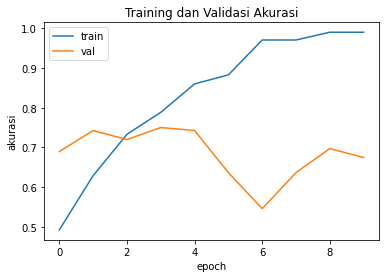

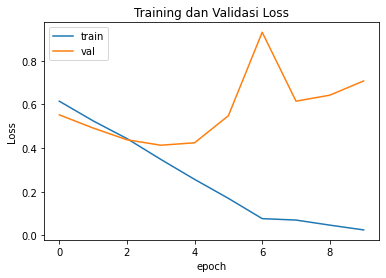

In [ ]:
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.title('Training dan Validasi Akurasi')
plt.ylabel('akurasi')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('Training dan Validasi Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(lstm.history['accuracy'])
print(lstm.history['val_accuracy'])

[0.4918566644191742, 0.628664493560791, 0.732899010181427, 0.7882736325263977, 0.8599348664283752, 0.8827361464500427, 0.9706840515136719, 0.9706840515136719, 0.990227997303009, 0.990227997303009]
[0.689393937587738, 0.7424242496490479, 0.7196969985961914, 0.75, 0.7424242496490479, 0.6363636255264282, 0.5454545617103577, 0.6363636255264282, 0.6969696879386902, 0.6742424368858337]


In [ ]:
print(lstm.history['loss'])
print(lstm.history['val_loss'])

[0.6143893599510193, 0.5243549346923828, 0.44319844245910645, 0.34798821806907654, 0.2564375698566437, 0.1694164276123047, 0.07652506977319717, 0.06994330137968063, 0.04675102233886719, 0.024833720177412033]
[0.5518530011177063, 0.4914436936378479, 0.4377419054508209, 0.41270899772644043, 0.4238300323486328, 0.5478127002716064, 0.9301841259002686, 0.6144580245018005, 0.6419607996940613, 0.7071740031242371]


##Prediksi Data Test

In [ ]:
prediksi = model.predict(X_test)
[print(listdata[i], prediksi[i], y_test[i]) for i in range (0,5)]
prediksi[:5]
y_DL, y_T = [], []
for x,y in zip (y_test, prediksi):
    if x[0]>x[1]:
      y_T.append('Neg')
    else:
      y_T.append('Pos')
    if y[0]>y[1]:
      y_DL.append('Neg')
    else:
      y_DL.append('Pos')
print(y_DL[:5])
print(y_T[:5])

jasa kirim parah pilih pengirinan yg expres tp ttp aja super duper jasa kirim yg guna kecewa klien sampe kirim paket jasa lg harap sumpah kesal banget [0.04389501 0.95563626 0.00917497] [1 0 0]
parah banget pakai jasa pos indonesia paket tgl 5 8 des 2020 gak tau juntrung mana posisi paket cek update dgn pakai aplikasi cm data kirim tkp pd tanggal pengitiman it aza it gak tau lg ntah sdh dmn posisi paket nys saing dgn jasa kirim yg kl gak ubah pelan pelan konsumen kspok lari jasa expedisi yg [0.04734653 0.00983071 0.9384465 ] [0 0 1]
ajar dl bikin aplikasi post play store ngabisin duit usaha aja mana duit rakyat aplikasi gak beres2 gin baik makan gaji buta jgn2 harga mahal dr pasar [9.978170e-01 8.104593e-03 1.835823e-04] [1 0 0]
tolong kurir barang sampek tolong uang setor pos lut banget uang ngendak gak kayak pos skrang bnyak kecewa tolong baik [0.7464389  0.30426532 0.0201844 ] [1 0 0]
kecewa [0.35223526 0.06519702 0.43372658] [1 0 0]
['Pos', 'Neg', 'Neg', 'Neg', 'Neg']
['Neg', 'Pos'

##Confussion Matrix

In [ ]:
print(confusion_matrix(y_T, y_DL))
print(classification_report(y_T, y_DL))

[[42  8]
 [36 24]]
              precision    recall  f1-score   support

         Neg       0.54      0.84      0.66        50
         Pos       0.75      0.40      0.52        60

    accuracy                           0.60       110
   macro avg       0.64      0.62      0.59       110
weighted avg       0.65      0.60      0.58       110



##Hasil Akurasi Data Test

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss : %.2f%%" % (score[0]))
print("Accuracy : %.2f%%" % (score[1]))

Test Loss : 0.57%
Accuracy : 0.68%


In [ ]:
data_test = list(df['content'][idx_test].values)
rating_test = list(df['score'][idx_test].values)
sentiment_test = y_DL
dict_tst = {'test data': data_test, 'hasil_sentiment': sentiment_test, 'rating':rating_test}
prediksi_test = pd.DataFrame(dict_tst)
prediksi_test.to_csv('prediksi_test.csv')